# S16 T01 Advanced Machine Learning

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob

## Exercici 1
Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.

### World Happiness Report
Happiness scored according to economic production, social support, etc.

Read and preprocess the data:

In [2]:
# Read the data into a dataframe
df_raw = pd.read_csv('2019.csv', sep=',')

In [3]:
# See an example of the data
df_raw[df_raw['Country or region']=='Argentina']

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
46,47,Argentina,6.086,1.092,1.432,0.881,0.471,0.066,0.05


In [4]:
df_raw.sort_values(by = ['Country or region'])['Country or region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Ethiopia', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Haiti',
       'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya',
       'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Lao

There are no regions, so I´ll rename the feature

In [5]:
df_raw = df_raw.rename(columns = {'Country or region' : 'Country'})

In [6]:
# Are ther any nulls?
df_raw.isnull().sum()

Overall rank                    0
Country                         0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

In [7]:
# Describe the posible values of the target
df_raw.Score.describe()

count    156.000000
mean       5.407096
std        1.113120
min        2.853000
25%        4.544500
50%        5.379500
75%        6.184500
max        7.769000
Name: Score, dtype: float64

Text(0.5, 1.0, 'Distribution of the target variable')

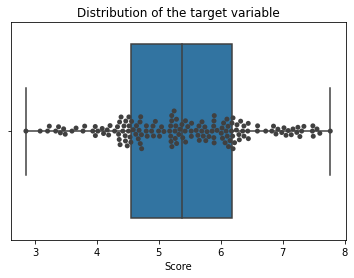

In [8]:
# What does it look like?
ax = sns.boxplot(x = df_raw['Score'], orient = 'h')
ax = sns.swarmplot(x = df_raw['Score'], orient = 'h', color=".25")
ax.set_title('Distribution of the target variable')

There are no outliers. All values are within 2 and 8.

In [9]:
features = df_raw.columns[3:9].values
print(f'Knowing {features}, I want to predict the Score')

Knowing ['GDP per capita' 'Social support' 'Healthy life expectancy'
 'Freedom to make life choices' 'Generosity' 'Perceptions of corruption'], I want to predict the Score


In [10]:
# Determine the features
X = df_raw[features].values
X

array([[1.34 , 1.587, 0.986, 0.596, 0.153, 0.393],
       [1.383, 1.573, 0.996, 0.592, 0.252, 0.41 ],
       [1.488, 1.582, 1.028, 0.603, 0.271, 0.341],
       [1.38 , 1.624, 1.026, 0.591, 0.354, 0.118],
       [1.396, 1.522, 0.999, 0.557, 0.322, 0.298],
       [1.452, 1.526, 1.052, 0.572, 0.263, 0.343],
       [1.387, 1.487, 1.009, 0.574, 0.267, 0.373],
       [1.303, 1.557, 1.026, 0.585, 0.33 , 0.38 ],
       [1.365, 1.505, 1.039, 0.584, 0.285, 0.308],
       [1.376, 1.475, 1.016, 0.532, 0.244, 0.226],
       [1.372, 1.548, 1.036, 0.557, 0.332, 0.29 ],
       [1.034, 1.441, 0.963, 0.558, 0.144, 0.093],
       [1.276, 1.455, 1.029, 0.371, 0.261, 0.082],
       [1.609, 1.479, 1.012, 0.526, 0.194, 0.316],
       [1.333, 1.538, 0.996, 0.45 , 0.348, 0.278],
       [1.499, 1.553, 0.999, 0.516, 0.298, 0.31 ],
       [1.373, 1.454, 0.987, 0.495, 0.261, 0.265],
       [1.356, 1.504, 0.986, 0.473, 0.16 , 0.21 ],
       [1.433, 1.457, 0.874, 0.454, 0.28 , 0.128],
       [1.269, 1.487, 0.92 , 0.

In [11]:
# Choose the target
label = ['Score']
y = np.ravel(df_raw[label].values) # use of ravel is because fit demanded a y with less dimensions
y

array([7.769, 7.6  , 7.554, 7.494, 7.488, 7.48 , 7.343, 7.307, 7.278,
       7.246, 7.228, 7.167, 7.139, 7.09 , 7.054, 7.021, 6.985, 6.923,
       6.892, 6.852, 6.825, 6.726, 6.595, 6.592, 6.446, 6.444, 6.436,
       6.375, 6.374, 6.354, 6.321, 6.3  , 6.293, 6.262, 6.253, 6.223,
       6.199, 6.198, 6.192, 6.182, 6.174, 6.149, 6.125, 6.118, 6.105,
       6.1  , 6.086, 6.07 , 6.046, 6.028, 6.021, 6.008, 5.94 , 5.895,
       5.893, 5.89 , 5.888, 5.886, 5.86 , 5.809, 5.779, 5.758, 5.743,
       5.718, 5.697, 5.693, 5.653, 5.648, 5.631, 5.603, 5.529, 5.525,
       5.523, 5.467, 5.432, 5.43 , 5.425, 5.386, 5.373, 5.339, 5.323,
       5.287, 5.285, 5.274, 5.265, 5.261, 5.247, 5.211, 5.208, 5.208,
       5.197, 5.192, 5.191, 5.175, 5.082, 5.044, 5.011, 4.996, 4.944,
       4.913, 4.906, 4.883, 4.812, 4.799, 4.796, 4.722, 4.719, 4.707,
       4.7  , 4.696, 4.681, 4.668, 4.639, 4.628, 4.587, 4.559, 4.548,
       4.534, 4.519, 4.516, 4.509, 4.49 , 4.466, 4.461, 4.456, 4.437,
       4.418, 4.39 ,

In [12]:
# Define the train and test groups
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30)

Build the pipeline and aplly Random Forest Regressor:

In [13]:
# Choose the parameters to test on Random Forest Regresor
parameters = {'RFR__random_state' : [5], 'RFR__n_estimators' : range(50,101,5),
              'RFR__min_samples_split' : [2,5,12,20], 'PCA__n_components' :[.95],
             'PCA__random_state' : [123]}


In [14]:
steps = [('scaler', StandardScaler()), ('PCA', PCA()), ('RFR', RandomForestRegressor())]

In [15]:
pipeline = Pipeline(steps) # define the pipeline object.

In [16]:
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('PCA', PCA()),
                                       ('RFR', RandomForestRegressor())]),
             param_grid={'PCA__n_components': [0.95],
                         'PCA__random_state': [123],
                         'RFR__min_samples_split': [2, 5, 12, 20],
                         'RFR__n_estimators': range(50, 101, 5),
                         'RFR__random_state': [5]})

In [17]:
print("Model score = %3.2f" %(grid.score(X_test,y_test)))
print('Best params:',grid.best_params_)

Model score = 0.81
Best params: {'PCA__n_components': 0.95, 'PCA__random_state': 123, 'RFR__min_samples_split': 5, 'RFR__n_estimators': 65, 'RFR__random_state': 5}


In [18]:
pred = grid.predict(X_test)

In [19]:
res = pd.DataFrame({'predicted': pred, 'real': y_test})
res

,predicted,real
0,6.174121,6.021
1,5.588178,5.323
2,4.605543,5.529
3,7.031388,7.278
4,5.760018,5.648
5,3.885044,3.597
6,7.055857,7.480
7,4.514075,4.913
8,6.611653,6.446
9,6.929801,7.494


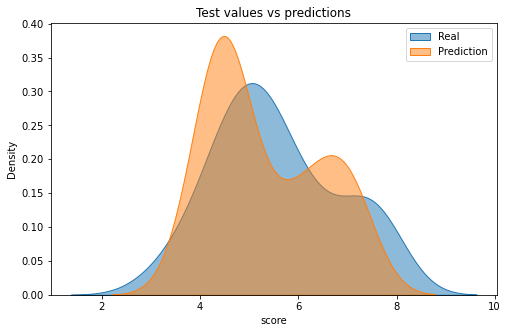

In [20]:
# Plot the difference between test values and predictions
plt.figure(figsize=(8,5))
plt.title('Test values vs predictions')
sns.kdeplot(res.real,  fill=True, alpha=.5, label='Real')
sns.kdeplot(data=res, x="predicted",  fill=True, alpha=.5, label='Prediction')
plt.xlabel('score')
plt.legend()


In [21]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
# the best mean squared error is the one closest to 0 
print('R Squared: ', metrics.r2_score(y_test,pred)) # how well fits dependent variables
# R squared is the score, it's better when is closer to 1

Mean Squared Error: 0.28092109471783067
R Squared:  0.8120773173730379


The plot and the metrics reflect that the model could be a little better. Maybe using more input data or trying with another scaler...

## Exercici 2
Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules

In [22]:
# read a text file already in the directory
f = open("modern-history.txt", "r")
text= f.read()
print(text)


Welcome to Modern World History!  This is the textbook for an undergraduate survey course taught at all the universities and most of the colleges in the Minnesota State system. Similar courses are taught at institutions around the United States and the world, so the authors have made the text available as an open educational resource that teachers and learners can read, adapt, and reuse to meet their needs. We’d like to hear from people who have found the text useful, and we’re always open to questions and suggestions.

Readers of this text may have varying levels of familiarity with the events of World History before the modern period we will be covering. Occasionally understanding the text may require a bit of background that will help contextualize the material we are covering. This introduction will cover some of that background.

The Agricultural Revolution
Farming developed in a number of different parts of the ancient world, before the beginning of recorded history. That means i

In [23]:
# I change the case to lower, 
# if I don´t do this 'The' and 'the' will be different words
text = text.lower()
text

'welcome to modern world history!  this is the textbook for an undergraduate survey course taught at all the universities and most of the colleges in the minnesota state system. similar courses are taught at institutions around the united states and the world, so the authors have made the text available as an open educational resource that teachers and learners can read, adapt, and reuse to meet their needs. we’d like to hear from people who have found the text useful, and we’re always open to questions and suggestions.\n\nreaders of this text may have varying levels of familiarity with the events of world history before the modern period we will be covering. occasionally understanding the text may require a bit of background that will help contextualize the material we are covering. this introduction will cover some of that background.\n\nthe agricultural revolution\nfarming developed in a number of different parts of the ancient world, before the beginning of recorded history. that m

In [24]:
# Use nltk to tokenize the words
# this first option takes punctuation marks as words
# words = word_tokenize(text)

# using this regular expression we leave behind punctuation marks
tokenizer = nltk.RegexpTokenizer(r"\w+")
words = tokenizer.tokenize(text)

print(words)

['welcome', 'to', 'modern', 'world', 'history', 'this', 'is', 'the', 'textbook', 'for', 'an', 'undergraduate', 'survey', 'course', 'taught', 'at', 'all', 'the', 'universities', 'and', 'most', 'of', 'the', 'colleges', 'in', 'the', 'minnesota', 'state', 'system', 'similar', 'courses', 'are', 'taught', 'at', 'institutions', 'around', 'the', 'united', 'states', 'and', 'the', 'world', 'so', 'the', 'authors', 'have', 'made', 'the', 'text', 'available', 'as', 'an', 'open', 'educational', 'resource', 'that', 'teachers', 'and', 'learners', 'can', 'read', 'adapt', 'and', 'reuse', 'to', 'meet', 'their', 'needs', 'we', 'd', 'like', 'to', 'hear', 'from', 'people', 'who', 'have', 'found', 'the', 'text', 'useful', 'and', 'we', 're', 'always', 'open', 'to', 'questions', 'and', 'suggestions', 'readers', 'of', 'this', 'text', 'may', 'have', 'varying', 'levels', 'of', 'familiarity', 'with', 'the', 'events', 'of', 'world', 'history', 'before', 'the', 'modern', 'period', 'we', 'will', 'be', 'covering', 'oc

In [25]:
# find the frequency distributions of words
fdist = FreqDist(words)
print(fdist)

<FreqDist with 1249 samples and 3993 outcomes>


List the most frecuent words:

In [26]:
# display the most frecuent words
fdist.most_common(15)

[('the', 315),
 ('and', 170),
 ('of', 164),
 ('in', 105),
 ('to', 81),
 ('a', 50),
 ('for', 32),
 ('as', 32),
 ('from', 28),
 ('years', 28),
 ('that', 26),
 ('by', 25),
 ('were', 25),
 ('roman', 25),
 ('their', 24)]

After the first 15 words the frecuency decreases a lot. Most of this "top ten" words add no meaning. Most are "stopwords". 


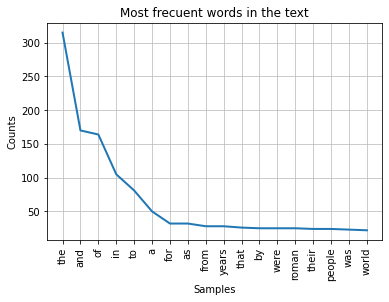

In [27]:
# plot the most frecuent words
fdist.plot(18,cumulative=False, title='Most frecuent words in the text')
plt.show()

# Nivell 2
## Exercici 1
Treu les stopwords i realitza stemming al teu conjunt de dades.

Drop the stopwords form the list of words:

In [28]:
# define the set of stopwords to use. 
# These are words with no meaning on its own
stop_words=set(stopwords.words("english"))
print(stop_words)

{'now', 'hers', 'but', 'won', 'didn', 'during', 'of', 'wasn', "hasn't", 'yourselves', 'above', 'not', "it's", 'through', 'how', 'aren', 'a', 'below', "you're", 'no', 'been', 'being', 'were', 'was', 'under', 'between', 'over', 'again', 'nor', 'most', 'each', 'd', 'too', 'ma', 'who', "aren't", 't', 'as', 're', 'mustn', 'ourselves', 'these', "you've", 'himself', 'have', 'and', 'off', 'needn', 'is', 'can', 'i', 'some', 'does', 'why', 'she', 'are', 'his', 'once', 'mightn', 'ain', 'because', "haven't", "didn't", 'isn', 'he', "wouldn't", 'against', 'o', 'for', 'couldn', 'this', 'don', "hadn't", 'few', "isn't", 'very', "doesn't", 'before', 'up', 'it', "shouldn't", 'or', "couldn't", 'did', 'other', "weren't", 'has', 'where', 'after', "she's", 'my', 'to', 'him', "don't", 'shan', 'that', 'myself', 'be', 'such', 'at', 'what', 'so', 'more', 'if', 'themselves', 'am', 'their', 'with', 'on', 've', 'hasn', "won't", 'they', 'yours', 'weren', "needn't", 'here', 'the', "that'll", 'in', 'ours', 'should', '

In [29]:
# remove the stopwords from the list of words
filtered=[]
for w in words:
    if w not in stop_words:
        filtered.append(w)
        
print("Filterd words:",filtered)

Filterd words: ['welcome', 'modern', 'world', 'history', 'textbook', 'undergraduate', 'survey', 'course', 'taught', 'universities', 'colleges', 'minnesota', 'state', 'system', 'similar', 'courses', 'taught', 'institutions', 'around', 'united', 'states', 'world', 'authors', 'made', 'text', 'available', 'open', 'educational', 'resource', 'teachers', 'learners', 'read', 'adapt', 'reuse', 'meet', 'needs', 'like', 'hear', 'people', 'found', 'text', 'useful', 'always', 'open', 'questions', 'suggestions', 'readers', 'text', 'may', 'varying', 'levels', 'familiarity', 'events', 'world', 'history', 'modern', 'period', 'covering', 'occasionally', 'understanding', 'text', 'may', 'require', 'bit', 'background', 'help', 'contextualize', 'material', 'covering', 'introduction', 'cover', 'background', 'agricultural', 'revolution', 'farming', 'developed', 'number', 'different', 'parts', 'ancient', 'world', 'beginning', 'recorded', 'history', 'means', 'difficult', 'historians', 'describe', 'early', 'agri

Normalize the data using Stemming, in order to reduce the noise (chops off the derivational affixes):

In [30]:
ps = PorterStemmer()

stemmed_words=[]
for w in filtered:
    stemmed_words.append(ps.stem(w))

print("Stemmed words:",stemmed_words)

Stemmed words: ['welcom', 'modern', 'world', 'histori', 'textbook', 'undergradu', 'survey', 'cours', 'taught', 'univers', 'colleg', 'minnesota', 'state', 'system', 'similar', 'cours', 'taught', 'institut', 'around', 'unit', 'state', 'world', 'author', 'made', 'text', 'avail', 'open', 'educ', 'resourc', 'teacher', 'learner', 'read', 'adapt', 'reus', 'meet', 'need', 'like', 'hear', 'peopl', 'found', 'text', 'use', 'alway', 'open', 'question', 'suggest', 'reader', 'text', 'may', 'vari', 'level', 'familiar', 'event', 'world', 'histori', 'modern', 'period', 'cover', 'occasion', 'understand', 'text', 'may', 'requir', 'bit', 'background', 'help', 'contextu', 'materi', 'cover', 'introduct', 'cover', 'background', 'agricultur', 'revolut', 'farm', 'develop', 'number', 'differ', 'part', 'ancient', 'world', 'begin', 'record', 'histori', 'mean', 'difficult', 'historian', 'describ', 'earli', 'agricultur', 'societi', 'much', 'detail', 'like', 'also', 'none', 'written', 'record', 'historian', 'typic',

In [31]:
# find the frequency distributions of words
fdist_s = FreqDist(stemmed_words)
fdist_s.most_common(15)

[('year', 31),
 ('roman', 30),
 ('empir', 28),
 ('peopl', 25),
 ('develop', 23),
 ('world', 22),
 ('000', 21),
 ('agricultur', 16),
 ('ago', 16),
 ('ancient', 15),
 ('china', 14),
 ('europ', 14),
 ('region', 13),
 ('began', 13),
 ('america', 13)]

Now we get the idea of what the text is about!!

# Nivell 3
## Exercici 1
Realitza sentiment analysis al teu conjunt de dades.

TextBlob measures polarity and subjectivity. 
* Polarity: from -1 to 1 (-1 defines a negative sentiment and 1 defines a positive sentiment) 
* Subjectivity from 0  to 1  (Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.)

In [40]:
def sentiment_analysis(text):
    # Get the polarity
    def getPolarity(text):
        score = TextBlob(text).sentiment.polarity
        print('Polarity:')
        if score < 0:
            print('Negative')
        elif score == 0:
            print('Neutral')
        else:
            print('Positive')
      
    # Get the subjectivity
    def getSubjectivity(text):
        score = TextBlob(text).sentiment.subjectivity
        if score < 0.5:
            print('Text is more objective')
        else:
            print('Text is more subjective')
            
    getPolarity(text)
    getSubjectivity(text)
 
sentiment_analysis(text)

Polarity:
Positive
Text is more objective


In [41]:
f.close()